In [28]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# RF Optimization

In [31]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
 data.make_diff_col()
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor ] )
print(x_cols)

data no fire has shape (77746, 15)
use default fire feature


['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000']

{'n_estimators': 160, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 2, 'max_depth': None, 'bootstrap': False} 0.01369357440798844
optimize 1 score {'val_r2_score': 0.05221266883633913, 'val_mean_squared_error': 40.18064965483873}


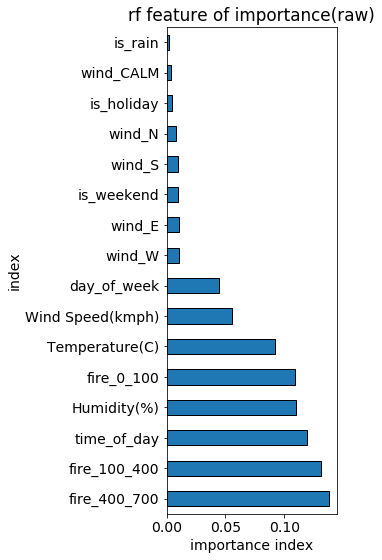

In [38]:
print('=================optimize 1: find the best RF model=================')
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=x_cols)
data.x_cols = x_cols

model = do_rf_search(xtrn,ytrn)
score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict)

importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(raw)')


In [39]:
print('=================optimize 2: remove unncessary columns=================')
# columns to consider droping are columns with low importance
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]

for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)

to_drop.reverse()
model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

=================optimize 2: remove unncessary columns=================
old cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')
drop wind_W
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2_score after dropping columns 0.05239219230489467


In [40]:
print('================= optimization 3: find the best fire feature ===================')
# reduce the number of split
data.split_data(split_ratio=[0.6, 0.2, 0.2])
data.fire_dict = sk_op_fire(data, model, trn_index=data.split_list[0], val_index=data.split_list[1])
print(data.fire_dict)

================= optimization 3: find the best fire feature ===================
skop_ fire use x_cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
old score 0.05122011519965075 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter using skopt optimizer. This will take about 20 mins
r2 score for the best fire parameters 0.05872747338753381


In [41]:
data.fire_dict

{'w_speed': 2, 'shift': -48, 'roll': 26}

In [42]:
print('================= optimization 4: optimize for the best RF again and search for other model in TPOT =================')

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]
fire_cols = data.merge_fire(data.fire_dict)
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=new_x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=new_x_cols)

print('optimize RF')
rf_model = do_rf_search(xtrn,ytrn)
rf_score_dict = cal_scores(ytest, rf_model.predict(xtest), header_str ='test_')
print(rf_score_dict)
rf_dict = rf_model.get_params()

================= optimization 4: optimize for the best RF again and search for other model in TPOT =================
optimize RF
{'n_estimators': 140, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 2, 'max_depth': None, 'bootstrap': True} 0.033492815495902814
{'test_r2_score': 0.12367580769263986, 'test_mean_squared_error': 24.0925587145206}


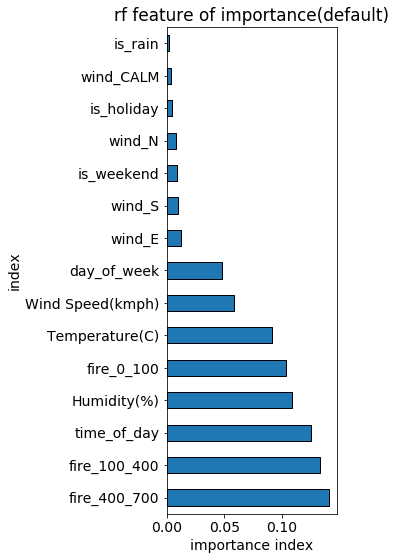

In [43]:
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(default)')

# Gaussian Process Regressor

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


In [49]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.make_diff_col()
data.fire_dict = {'w_speed': 2, 'shift': -48, 'roll': 26}
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor ] )
print(x_cols)

print('=================optimize 1: find the best model=================')
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=x_cols)
data.x_cols = x_cols

data no fire has shape (77746, 15)
use default fire feature
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')
=================optimize 1: find the best model=================


In [47]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5),
          ConstantKernel(1.0, (1e-1, 1e3)) * RBF(10.0, (1e-3, 1e3))]

In [50]:
for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(xtrn, ytrn)
    ypred, ystd = gp.predict(xval)
    score_dict = cal_scores(yval, ypred, header_str ='val_')
    print(score_dict)


MemoryError: Unable to allocate 7.21 GiB for an array with shape (31098, 31098, 1) and data type float64